# Install packages

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.6 MB/s eta 0:00:00


In [ ]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import Dataset,load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Import data

In [ ]:
data_preprocessed = pd.read_json('data/training_data_preprocessed.json')
data_preprocessed.head(1)

,content,language,retweet_count,reply_count,like_count,quote_count,impression_count,engagement_rate,language_category,content_category,hashtag,mentions,emojis,emoji_count,clean,word_count,hashtag_count,mention_count
0,Ukraine in power is donating food to a country...,en,1,0,1,0,643,0.00311,en,tweet,[],[StateHouseKenya],[],0,ukraine power donating food country kshs used ...,64,0,1


For AutoModel, the data should be in a form of 2 columns, one is the text, the other is called label.

In [ ]:
df = data_preprocessed[['clean','engagement_rate']]
df = df.rename(columns={'clean':'text','engagement_rate':'label'})
df

,text,label
0,ukraine power donating food country kshs used ...,0.003110
1,paul mashatile paying alot money get food parc...,0.014706
2,sushi temple com click,0.013514
3,plant metabolic engineers growing proteins pot...,0.016194
4,mom likes brown much remember told little thin...,0.009009
...,...,...
4281,first time skz cafe food member menu items bel...,0.015859
4282,lil food dump,0.009351
4283,phleb instructor offered doordash food since e...,0.017857
4284,everytime disability makes way tired function ...,0.040000


Check the distribution of the engagement rates

In [ ]:
df.describe()

,label
count,4286.000000
mean,0.017994
std,0.011273
min,0.000159
25%,0.008547
50%,0.016129
75%,0.026316
max,0.042889


The margin between min and max is quite low, which is something to keep in mind while choosing the metrics.

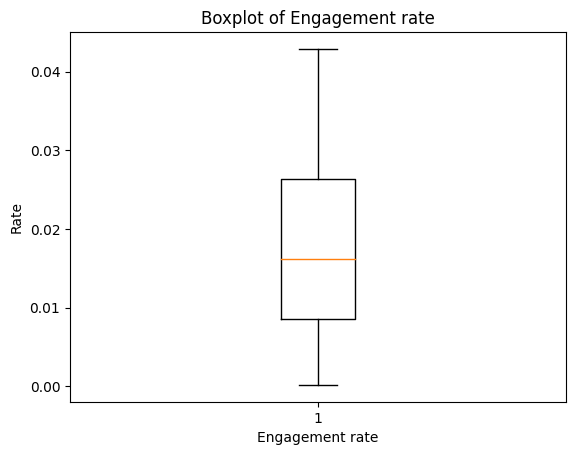

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create the boxplot
ax.boxplot(df['label'])

# Set labels and title
ax.set_xlabel('Engagement rate')
ax.set_ylabel('Rate')
ax.set_title('Boxplot of Engagement rate')

# Display the plot
plt.show()

# Convert dataframe to dataset

In [ ]:
dataset = Dataset.from_pandas(df,preserve_index=False)
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3428
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 858
    })
})

# Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
print(tokenizer(df['text'][0])['input_ids'])

[101, 5924, 2373, 24260, 3436, 2833, 2406, 29535, 7898, 2109, 3679, 5572, 27529, 102]


In [ ]:
print([tokenizer.decode(i) for i in tokenizer(df['text'][0])['input_ids']])

['[CLS]', 'ukraine', 'power', 'dona', '##ting', 'food', 'country', 'ks', '##hs', 'used', 'daily', 'tea', 'biscuits', '[SEP]']


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3428 [00:00<?, ? examples/s]

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

# Fine-tuning BERT for regression problem

For regression problem , we have to pass num_labels=1.



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Metrics function

Since this is a regression problem, we need metrics to measure the distance between the predicted and the true value. Here, we chose the common measurures (MSE, MAE, R-Squared and Accuracy with a threshold = 0.02 - the mean of engagement rate).

In [ ]:
from datasets import load_metric
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score


def compute_metrics(eval_pred,threshold=0.02):
    predictions, labels = eval_pred
    r2 = r2_score(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)

    # Calculate accuracy
    binary_predictions = [1 if pred > threshold else 0 for pred in predictions]
    binary_labels = [1 if label > threshold else 0 for label in labels]

    accuracy = accuracy_score(binary_labels, binary_predictions)

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}


# Train the model

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
training_args = TrainingArguments(output_dir="data/test_trainer",
                                logging_strategy="epoch",
                                evaluation_strategy="epoch",
                                per_device_train_batch_size=16,
                                per_device_eval_batch_size=16,
                                num_train_epochs=20,
                                save_total_limit =0,
                                save_strategy = 'no',
                                load_best_model_at_end=False
                                )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.000000,0.000157,0.000157,0.010241,-0.191379,0.534965
2,0.000000,0.000158,0.000158,0.010335,-0.197889,0.537296
3,0.000000,0.000171,0.000171,0.010905,-0.298381,0.497669
4,0.000000,0.000156,0.000156,0.010281,-0.187076,0.539627
5,0.000000,0.000165,0.000165,0.010496,-0.253049,0.530303
6,0.000000,0.000160,0.000160,0.010281,-0.210916,0.541958
7,0.000000,0.000163,0.000163,0.010334,-0.238580,0.532634
8,0.000000,0.000163,0.000163,0.010327,-0.238060,0.532634
9,0.000000,0.000156,0.000156,0.010267,-0.181614,0.536131
10,0.000000,0.000163,0.000163,0.010446,-0.238631,0.522145


TrainOutput(global_step=4300, training_loss=4.711172023658143e-06, metrics={'train_runtime': 1318.5108, 'train_samples_per_second': 51.998, 'train_steps_per_second': 3.261, 'total_flos': 9081802887905280.0, 'train_loss': 4.711172023658143e-06, 'epoch': 20.0})

# Evaluate the model

Because of memory constraints, we could not save the results after each epoch and therefore, could not load the best model from the code above. So manually, we took the data table and mapped them out in graphs for evaluation.

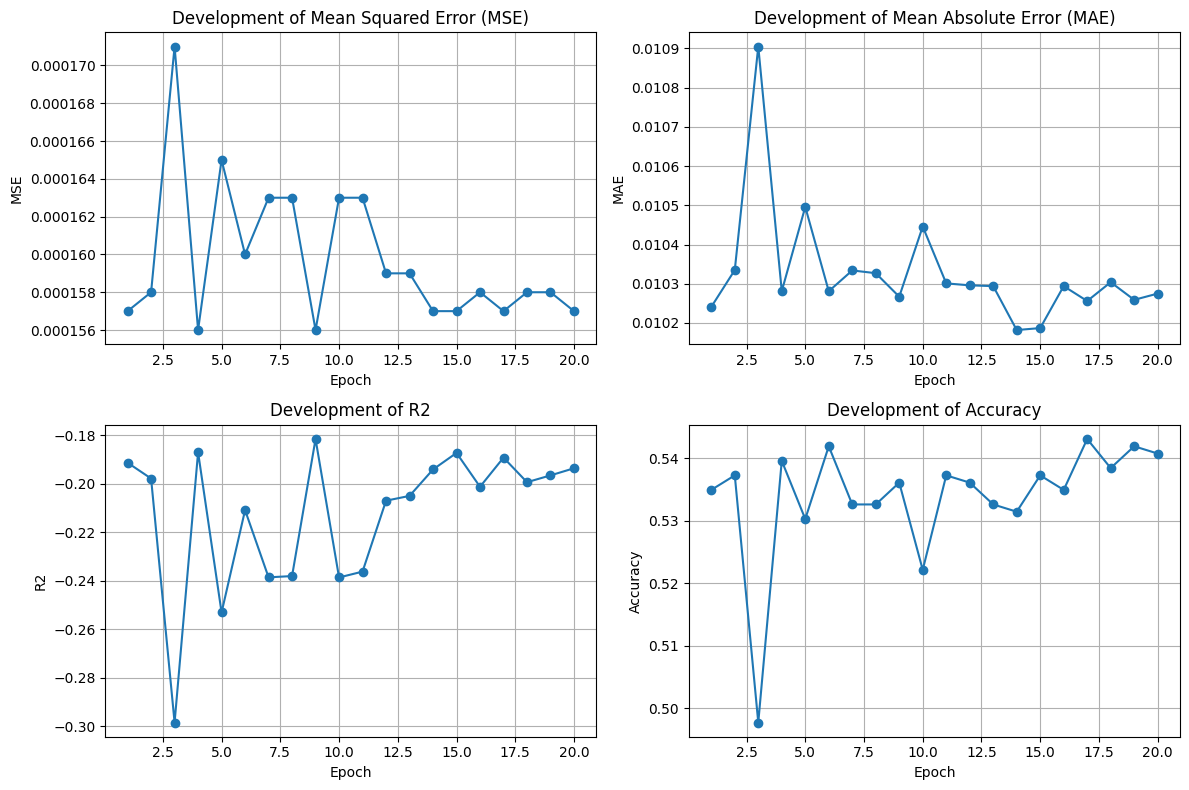

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20
]
mse = [
    0.000157, 0.000158, 0.000171, 0.000156, 0.000165,
    0.000160, 0.000163, 0.000163, 0.000156, 0.000163,
    0.000163, 0.000159, 0.000159, 0.000157, 0.000157,
    0.000158, 0.000157, 0.000158, 0.000158, 0.000157
]
mae = [
    0.010241, 0.010335, 0.010905, 0.010281, 0.010496,
    0.010281, 0.010334, 0.010327, 0.010267, 0.010446,
    0.010301, 0.010296, 0.010294, 0.010182, 0.010187,
    0.010294, 0.010256, 0.010304, 0.010259, 0.010275
]
r2 = [
    -0.191379, -0.197889, -0.298381, -0.187076, -0.253049,
    -0.210916, -0.238580, -0.238060, -0.181614, -0.238631,
    -0.236224, -0.207013, -0.205044, -0.194155, -0.187348,
    -0.201284, -0.189285, -0.199401, -0.196594, -0.193662
]
accuracy = [
    0.534965, 0.537296, 0.497669, 0.539627, 0.530303,
    0.541958, 0.532634, 0.532634, 0.536131, 0.522145,
    0.537296, 0.536131, 0.532634, 0.531469, 0.537296,
    0.534965, 0.543124, 0.538462, 0.541958, 0.540793
]

# Segmenting the plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plotting MSE development
axs[0, 0].plot(epochs, mse, marker='o')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_title('Development of Mean Squared Error (MSE)')
axs[0, 0].grid(True)

# Plotting MAE development
axs[0, 1].plot(epochs, mae, marker='o')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].set_title('Development of Mean Absolute Error (MAE)')
axs[0, 1].grid(True)

# Plotting R2 development
axs[1, 0].plot(epochs, r2, marker='o')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('R2')
axs[1, 0].set_title('Development of R2')
axs[1, 0].grid(True)

# Plotting accuracy development
axs[1, 1].plot(epochs, accuracy, marker='o')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Development of Accuracy')
axs[1, 1].grid(True)

# Adjusting the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()


*   Generally, R2 is constantly negative over the epochs, meaning the model is predicting worse than taking the mean of the data. However, considering the small margin of our data, R2 may not be the best fit.

* MSE and MAE both have the same pattern, and tend to decrease over time. For a small margin like this, these are better for evaluating the model, and also more interpetable.

* MAE may be more interpretable and usable in this case, because MSE is normally used to exaggerate the larger error, whose effect we do not want to.

* Also, MAE is constantly smaller than the mean 0.02, which shows that the model is quite good.

* We could also see that in accuracy, when we set the threshold as the mean, most of the time the model performs better than the threshold, except for one case that it goes below 50%.





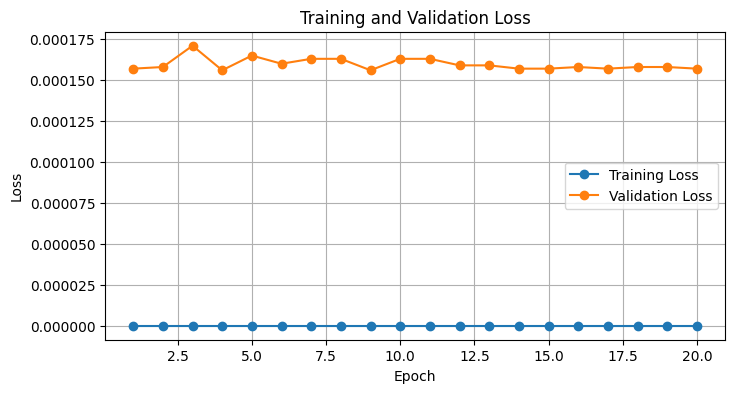

In [ ]:
training_loss = [
    0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
    0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
    0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
    0.000000, 0.000000, 0.000000, 0.000000, 0.000000
]
validation_loss = [
    0.000157, 0.000158, 0.000171, 0.000156, 0.000165,
    0.000160, 0.000163, 0.000163, 0.000156, 0.000163,
    0.000163, 0.000159, 0.000159, 0.000157, 0.000157,
    0.000158, 0.000157, 0.000158, 0.000158, 0.000157
]

# Plotting training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


This proves that the model is not generalizing well on unseen data -> overfitting issue.

# Save the pre-trained model

In [ ]:
# save the model
model.save_pretrained("data/RegressionModel")